In [1]:
#importing new slides
import pandas as pd 
import requests 
from bs4 import BeautifulSoup 
import time 
import random 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import geopandas as gp
import folium
import mapclassify
from pandas import DataFrame

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)
import os
# Misc
import warnings
warnings.filterwarnings("ignore")



In [2]:
#loading in data 
cwd = os.getcwd()

#loading in Shape file
countyshp=('/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/USA_Counties/USA_Counties.shp')
countyshp=gp.read_file(countyshp)

#loading in csvs 
incpath=(cwd+"/Data/incarceration_trends.csv")
incdat = pd.io.parsers.read_csv(incpath, dtype={'fips': 'str'})
incdat2018=incdat.query("year == 2018")

unemployment="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Unepmloyment_Dat.csv"
unemploymentdat=pd.io.parsers.read_csv(unemployment, dtype={'FIPS_Code': 'str'})

poverty="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Poverty_dat.csv"
povertydat=pd.io.parsers.read_csv(poverty, dtype={'FIPStxt': 'str'})

envpath="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/ctyfactbook2020 (2).csv"
envpathdat=pd.io.parsers.read_csv(envpath, dtype={'County FIPS Code': 'str'})

edcat="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Education_by_County.csv"
eddat=pd.io.parsers.read_csv(edcat, dtype={'FIPS Code': 'str'})

#reading in policts
votedat = pd.read_csv("/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/countypres_2000-2020.tab",sep='\t',header=(0), 
dtype={'county_fips': 'str'} )

polpath="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/Poldat.csv"
policedat=pd.io.parsers.read_csv(polpath, dtype={'FIPS': 'str'})

#reading in policts
demdat="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/cc-est2019-alldata.csv"
demdat=pd.io.parsers.read_csv(demdat, dtype={'STATE': 'str', 'COUNTY': 'str'})

#reading in policts
rural="/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/Final Project/Incarceration-Rates-by-County/County Level Data/ruralurbancodes2013.csv"
ruraldat=pd.io.parsers.read_csv(rural, dtype={'FIPS': 'str'})

In [4]:
#filtering incarceration data to 2018
incdat2018=incdat.query("year == 2018")
incdat2018=incdat2018.rename(columns={'fips': 'FIPS'})
incdat2018=incdat2018[['year','FIPS', 'state',  'total_pop',
'total_pop_15to64', 'total_jail_pop', 'total_jail_pop_rate']]

#creating generic column to merge on
unemploymentdat=unemploymentdat.rename(columns={'FIPS_Code': 'FIPS'})

povertydat=povertydat.rename(columns={'FIPStxt': 'FIPS'})

envpathdat=envpathdat.rename(columns={'County FIPS Code': 'FIPS'})

eddat=eddat.rename(columns={'FIPS Code': 'FIPS'})

votedat['county_fips'] = votedat['county_fips'].astype(str).str.zfill(5)

votedat=votedat.rename(columns={'county_fips': 'FIPS'})
votedat=votedat.query("year == 2016")
votedat=votedat.query("candidate == 'DONALD TRUMP'")
votedat['RepPCT']=(votedat['candidatevotes']/votedat['totalvotes'])

policedat=policedat.rename(columns={'FIPS': 'STATE'})
demdat = demdat.merge(policedat, how='left', on='STATE')

demdat["FIPS"] =demdat["STATE"] + demdat["COUNTY"]
demdat=demdat.query("YEAR == 7")
demdat=demdat.query("AGEGRP == 0")
demdat['WhitePCT'] = (demdat['WA_MALE']+demdat['WA_FEMALE'])/demdat['TOT_POP']

combineddat = unemploymentdat.merge(povertydat, how='left', on='FIPS').merge(eddat, how='left', on='FIPS').merge(envpathdat, how='left', on='FIPS').merge(votedat, how='left', on='FIPS').merge(demdat, how='left', on='FIPS').merge(ruraldat, how='left', on='FIPS')

master_df = incdat2018.merge(combineddat, how='left', on='FIPS')
master_df=master_df.query("total_jail_pop_rate < 5000")

pred_dat=master_df[['total_jail_pop_rate', 'total_pop', 
'Percent of adults with less than a high school diploma, 2015-19' , 'Percent of adults with a high school diploma only, 2015-19',
"Percent of adults with a bachelor's degree or higher, 2015-19", 
'Unemployment_rate_2018', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'WhitePCT', 'RepPCT', 'Policing & Corrections Per Capita Spend', 'RUCC_2013']]

countymap = countyshp.merge(master_df, how='left', on="FIPS")

In [60]:
pred_dat.to_csv('Final_Cleaned_Data_Frame.csv')

total_jail_pop_rate                                                float64
total_pop                                                            int64
Percent of adults with less than a high school diploma, 2015-19    float64
Percent of adults with a high school diploma only, 2015-19         float64
Percent of adults with a bachelor's degree or higher, 2015-19      float64
Unemployment_rate_2018                                             float64
PCTPOVALL_2019                                                     float64
Median_Household_Income_2019                                       float64
WhitePCT                                                           float64
RepPCT                                                             float64
Policing & Corrections Per Capita Spend                            float64
RUCC_2013                                                          float64
dtype: object


,total_jail_pop_rate,total_pop,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",Unemployment_rate_2018,PCTPOVALL_2019,Median_Household_Income_2019,WhitePCT,RepPCT,Policing & Corrections Per Capita Spend,RUCC_2013
193,192.55,1150215,10.5,17.3,42.4,3.2,7.9,106555.0,0.675454,0.248739,907.0,1.0
1240,312.61,103923,9.5,34.6,19.3,4.8,13.4,50130.0,0.949456,0.534723,535.0,3.0
1457,372.39,11931,17.0,40.4,10.7,6.1,19.9,43106.0,0.784286,0.761230,435.0,3.0
961,205.29,6562,9.4,33.1,19.6,3.1,14.0,65141.0,0.916154,0.715520,509.0,7.0
505,653.57,2279,35.3,35.4,7.1,5.7,22.8,35522.0,0.512035,0.550766,472.0,9.0
2967,244.37,269805,5.2,22.2,33.2,4.6,7.5,79268.0,0.835836,0.394298,545.0,2.0
1011,605.58,39135,10.5,32.1,28.5,3.8,16.5,45574.0,0.921669,0.645959,387.0,7.0
219,224.77,2450758,18.0,26.9,22.3,4.5,11.3,72905.0,0.806083,0.443501,907.0,1.0
2090,318.43,65256,12.1,44.5,12.5,4.4,14.8,51479.0,0.909912,0.644366,540.0,4.0
2437,961.82,31756,19.9,38.0,16.1,4.2,19.7,40116.0,0.967914,0.800931,502.0,6.0


total_jail_pop_rate                                                 0
total_pop                                                           0
Percent of adults with less than a high school diploma, 2015-19     0
Percent of adults with a high school diploma only, 2015-19          0
Percent of adults with a bachelor's degree or higher, 2015-19       0
Unemployment_rate_2018                                              0
PCTPOVALL_2019                                                      0
Median_Household_Income_2019                                        0
WhitePCT                                                            0
RepPCT                                                             11
Policing & Corrections Per Capita Spend                             0
RUCC_2013                                                           0
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)


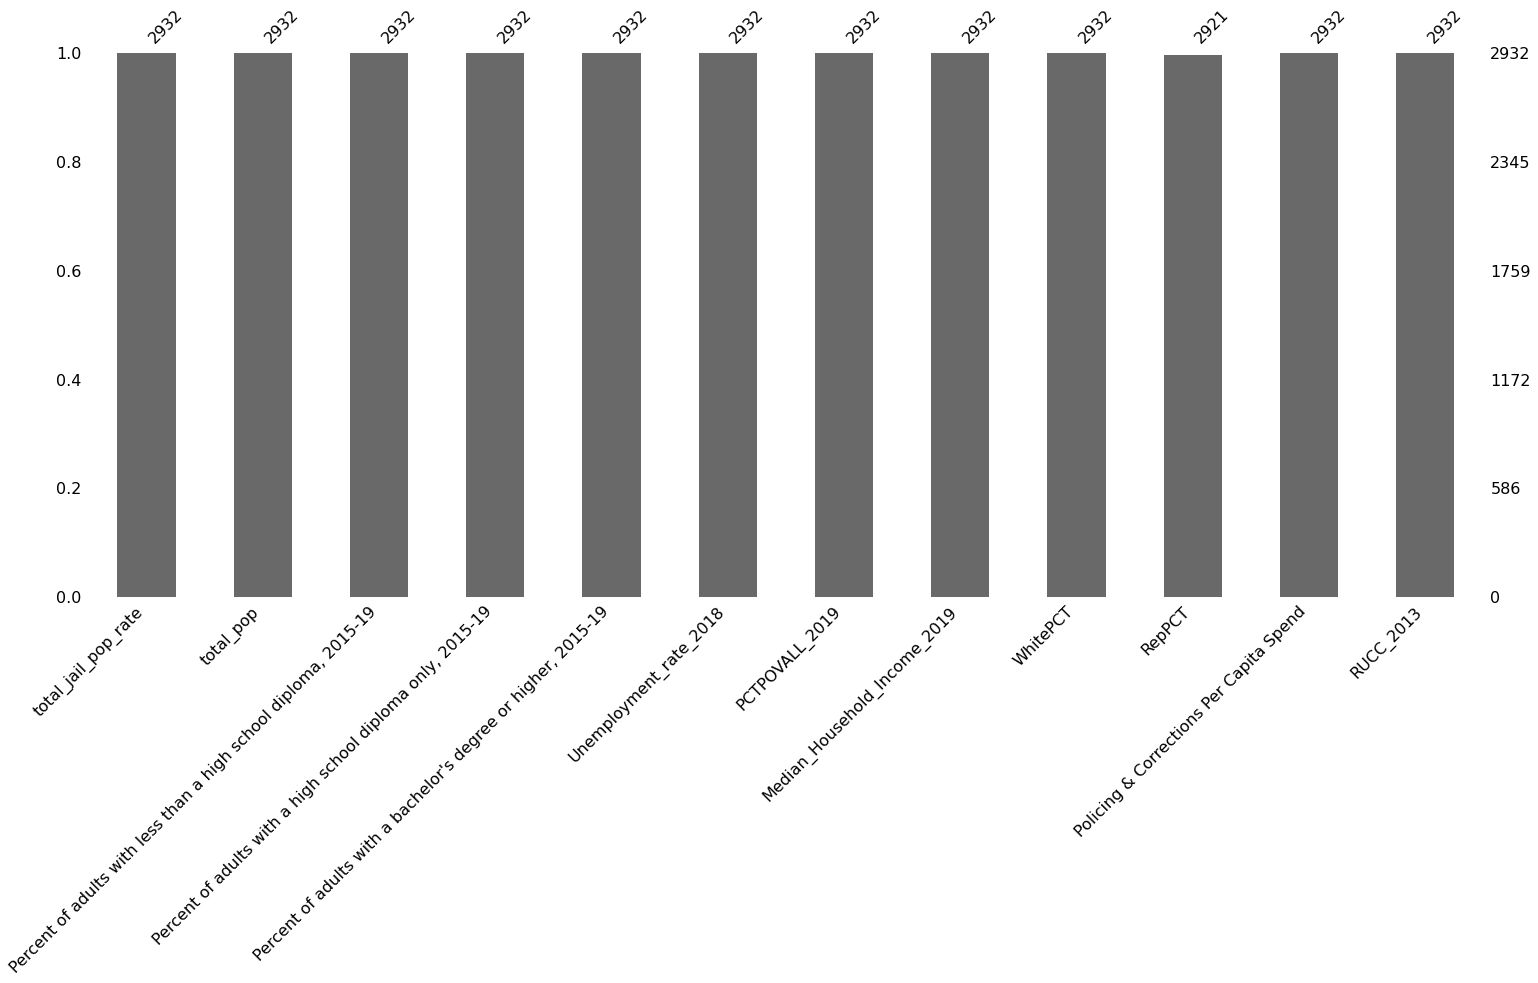

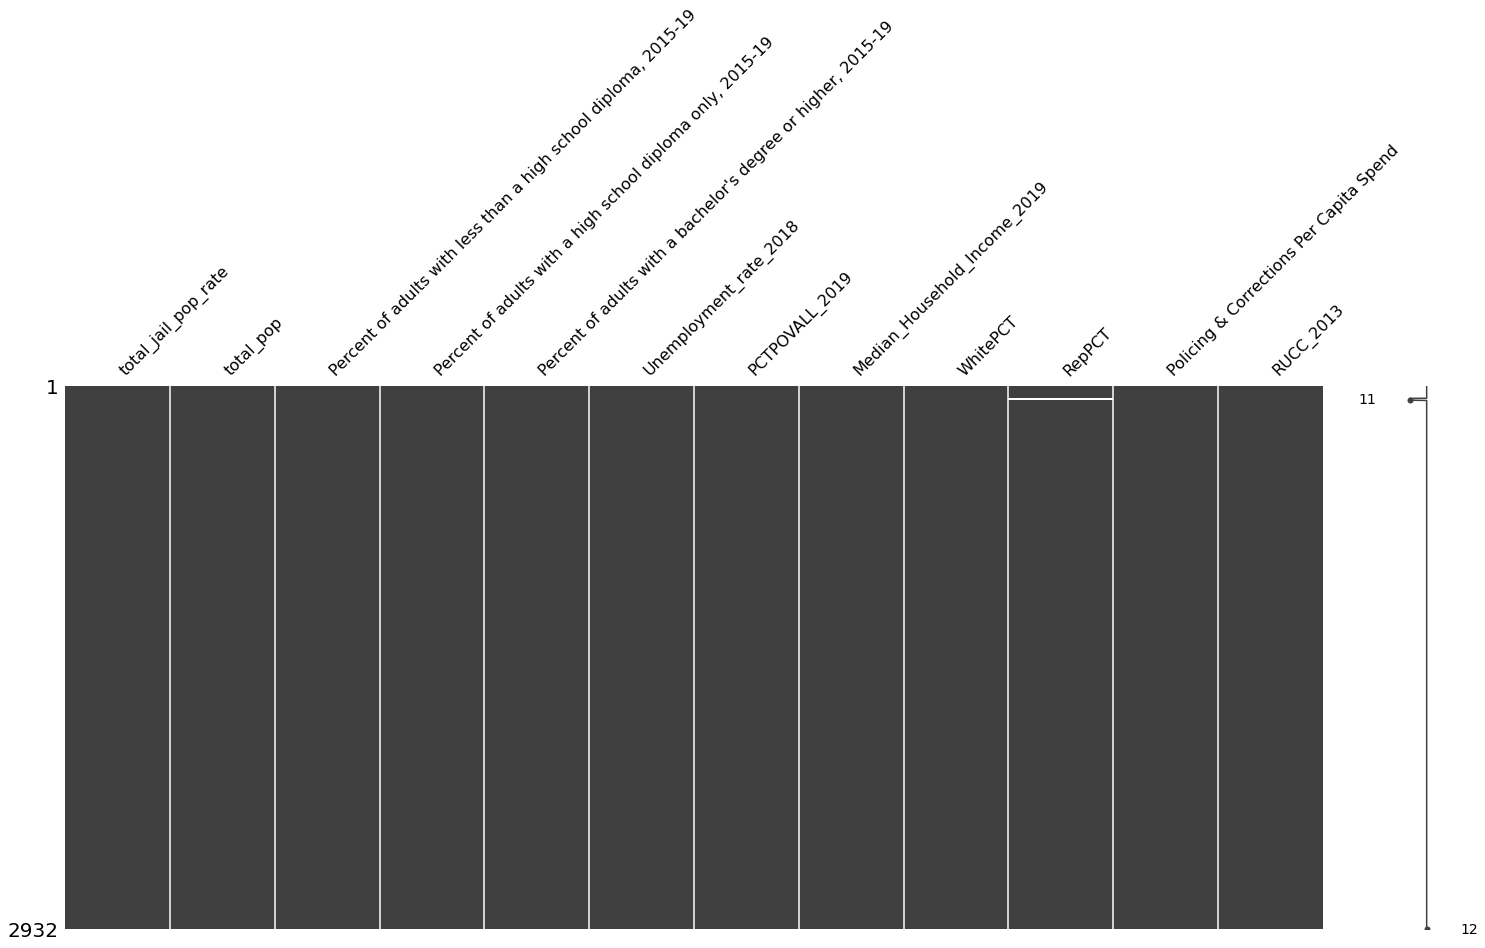

In [5]:
#getting data types 
print(pred_dat.dtypes)
#randomsample
display(pred_dat.sample(n = 20, replace = False))
#nulls by column 
print(pred_dat.isnull().sum())
#miss matrix
print(miss.bar(pred_dat))
#bar plot of missingness 
print(miss.matrix(pred_dat))

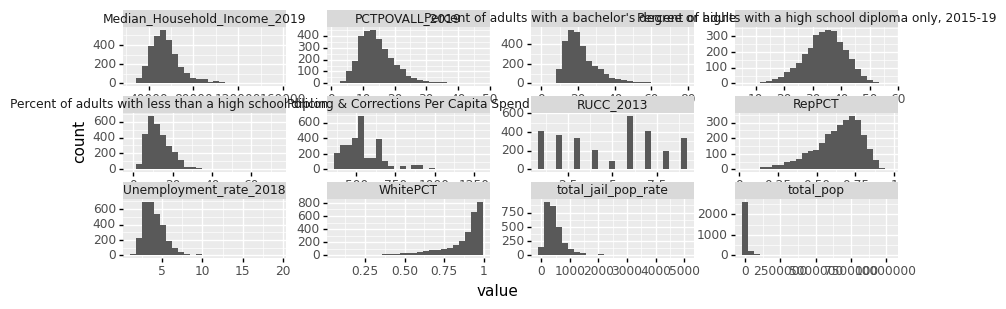

<ggplot: (8778653155154)>

In [6]:
#select_dtypes(include ="float")
#VIZING INTS
dist = pred_dat.melt()
(
    ggplot(dist ,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

In [7]:
#splitting Data 
pred_dat=pred_dat.dropna()

y = pred_dat[['total_jail_pop_rate']]
x = pred_dat.drop(columns=['total_jail_pop_rate'])
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = .25,random_state=202011)


print(train_x.shape[0]/pred_dat.shape[0])
print(test_x.shape[0]/pred_dat.shape[0])

0.749743238616912
0.250256761383088


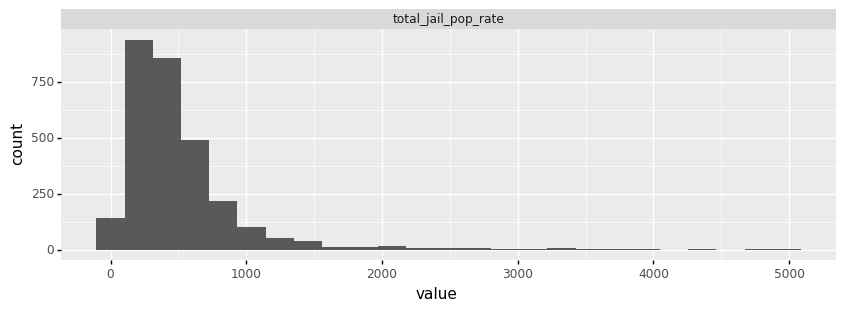

<ggplot: (8778652687345)>

In [8]:
dist = y.melt()
(
    ggplot(dist ,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

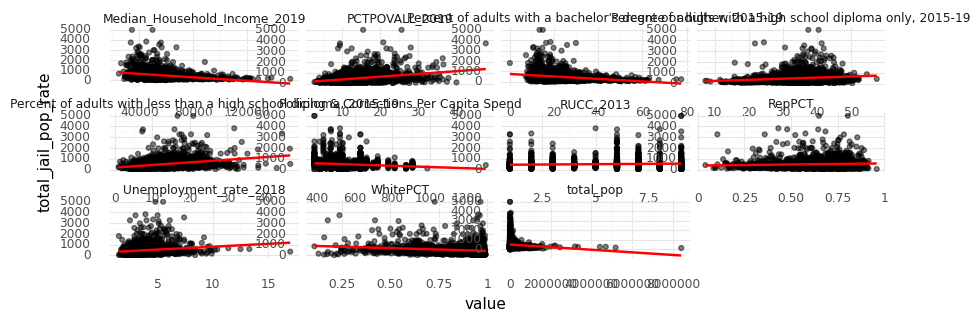

<ggplot: (8778652687156)>

In [9]:
D = train_x.copy()
D['total_jail_pop_rate'] = train_y

(
    ggplot(D.melt(id_vars=["total_jail_pop_rate"]),
           aes(x="value",y="total_jail_pop_rate"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [10]:
display(pred_dat[:20])

,total_jail_pop_rate,total_pop,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",Unemployment_rate_2018,PCTPOVALL_2019,Median_Household_Income_2019,WhitePCT,RepPCT,Policing & Corrections Per Capita Spend,RUCC_2013
0,454.81,55601,11.5,33.6,26.6,3.6,12.1,58233.0,0.782340,0.727666,449.0,2.0
1,477.31,218022,9.2,27.7,31.9,3.6,10.1,59871.0,0.872188,0.765457,449.0,3.0
2,702.18,24881,26.8,35.6,11.6,5.1,27.1,35972.0,0.499944,0.520967,449.0,6.0
3,556.00,22400,20.9,44.9,10.4,4.0,20.3,47918.0,0.767525,0.764032,449.0,1.0
4,369.20,57840,19.5,33.4,13.1,3.5,16.3,52902.0,0.961444,0.893348,449.0,1.0
5,479.19,10138,25.3,40.3,12.1,4.6,30.0,31906.0,0.261652,0.242038,449.0,6.0
6,639.22,19680,15.0,45.2,16.1,4.7,21.6,39944.0,0.533576,0.561269,449.0,6.0
7,673.96,114277,15.6,32.8,18.5,4.6,17.2,47747.0,0.758405,0.686633,449.0,3.0
8,700.91,33615,18.4,36.7,13.3,3.9,19.6,42015.0,0.579186,0.564245,449.0,6.0
9,780.47,26032,18.4,40.3,12.8,3.6,15.9,45982.0,0.932651,0.834156,449.0,6.0


In [11]:

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['total_pop', 
'Percent of adults with less than a high school diploma, 2015-19' , 'Percent of adults with a high school diploma only, 2015-19',
"Percent of adults with a bachelor's degree or higher, 2015-19", 
'Unemployment_rate_2018', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'WhitePCT', 'RepPCT', 'Policing & Corrections Per Capita Spend', 'RUCC_2013'])])

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['total_pop',
                                                                          'Percent '
                                                                          'of '
                                                                          'adults '
                                                                          'with '
                                                                          'less '
                                                                          'than '
                                                                          'a '
                                                

In [12]:
print(search.best_score_)

search.best_params_

-170269.96385201882


{'model': LinearRegression()}

In [13]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)
print(m.mean_squared_error(test_y,pred_y))
m.r2_score(test_y,pred_y)

232468.05013642562


0.09001311997143457

In [14]:
pred_y = DataFrame(pred_y,columns=['pred'])
pred_y = pred_y['pred'].tolist()
test_y=test_y['total_jail_pop_rate'].tolist()

In [34]:
p=(
    ggplot(pd.DataFrame(dict(Predicted_Value=pred_y,True_Value=test_y)),
          aes(x='Predicted_Value',y="True_Value")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7)) +
    labs(y="True Value", x="Predicted Value", title="Figure 4: Model Fit")
)

ggsave(plot = p, filename = "Figure4", path = cwd)



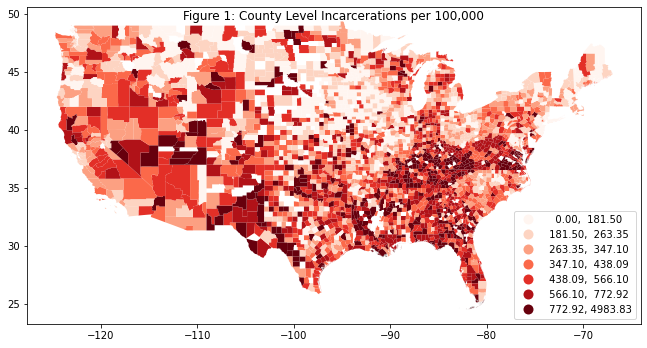

In [54]:

not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 1: County Level Incarcerations per 100,000", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column='total_jail_pop_rate', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))
plt.savefig('Figure1', edgecolor='white', dpi=300)

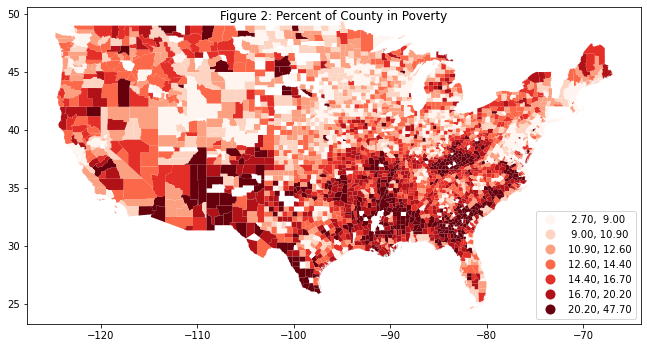

In [56]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 2: Percent of County in Poverty", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column="PCTPOVALL_2019", cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

plt.savefig('Figure2', edgecolor='white', dpi=300)

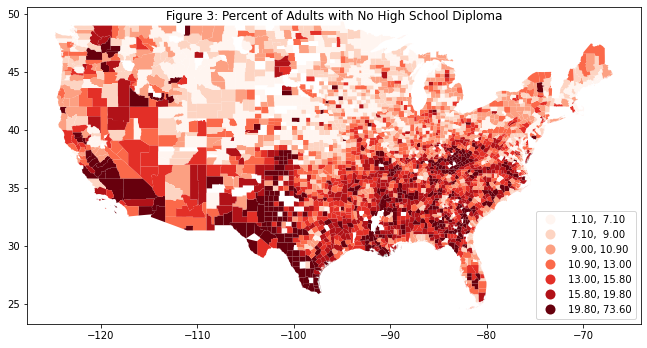

In [58]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Figure 3: Percent of Adults with No High School Diploma", x=.5, y=.94, fontname="DejaVu Sans"),
(mainland_usa.plot(column='Percent of adults with less than a high school diploma, 2015-19', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))
plt.savefig('Figure3', edgecolor='white', dpi=300)

<AxesSubplot:title={'center':'Fiugre 4: Percent of Adults Unemployed'}>

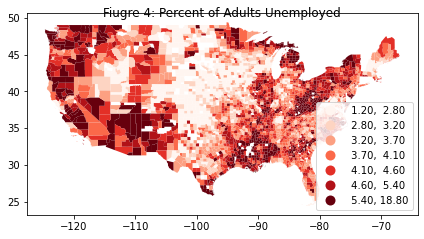

In [43]:

not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("Fiugre 4: Percent of Adults Unemployed", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column='Unemployment_rate_2018', cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

<AxesSubplot:title={'center':'2016 Republican Vote share'}>

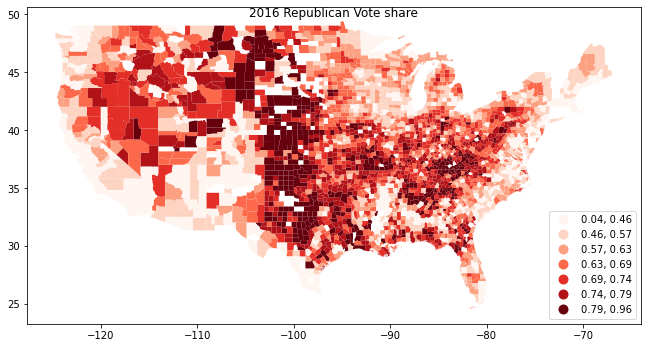

In [20]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
fig, ax = plt.subplots(1, 1, figsize=[11,8])
plt.title("2016 Republican Vote share", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column="RepPCT", cmap='Reds', scheme='quantiles', k=7, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}))

In [21]:
rf_mod=search.best_estimator_
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=25)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

vi_dat

,variable,vi,std,low,high
0,Percent of adults with less than a high school...,0.099310,0.010358,0.078595,0.120026
1,WhitePCT,0.026533,0.003992,0.018548,0.034517
2,PCTPOVALL_2019,0.023435,0.004159,0.015117,0.031753
3,RepPCT,0.019494,0.004067,0.011360,0.027627
4,total_pop,0.007698,0.002755,0.002187,0.013208
5,Percent of adults with a bachelor's degree or ...,0.006761,0.002214,0.002333,0.011190
6,Percent of adults with a high school diploma o...,0.006406,0.002221,0.001965,0.010847
7,Median_Household_Income_2019,0.005725,0.001896,0.001933,0.009518
8,RUCC_2013,0.005409,0.002205,0.000998,0.009820
9,Policing & Corrections Per Capita Spend,0.002227,0.001407,-0.000587,0.005042


In [33]:
# Plot
rv=(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(title= "Figure 5: Reduction by Variable", y="Reduction in Mean Squared Error",x="")
)

ggsave(plot = rv, filename = "Figure5", path = cwd)

#### Lessons
- Geospatial techniques in python 
- Practice tuning machine learning models 
- Biggest obstacle so far has been cleaning data
- Learn some time series techniques, and more advanced spatial machine learning 

In [23]:
pred_dat["total_jail_pop_rate"].mean()


501.1670455323515